In [87]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os

In [5]:
# Abre el archivo GeoTIFF
dataset = rasterio.open('..\\data\\Zona\\of5mtif1678296896753.tif')

# Imprime información sobre el archivo
print(f'Número de bandas: {dataset.count}')
print(f'Tamaño del archivo: {dataset.width}x{dataset.height}')
print(f'Sistema de coordenadas: {dataset.crs}')

Número de bandas: 3
Tamaño del archivo: 13734x13638
Sistema de coordenadas: EPSG:25831


In [75]:
def image_to_window(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin / transform.a, ymin / transform.a, xmax / transform.a, ymax / transform.a

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    return int(xmin), int(ymin), int(xmax), int(ymax)

def window_to_image(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin * transform.a, ymin * transform.a, xmax * transform.a, ymax * transform.a

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    return int(xmin), int(ymin), int(xmax), int(ymax)

def xyxy_to_cxcywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    return x, y, w, h

def cxcywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    return xmin, ymin, xmax, ymax

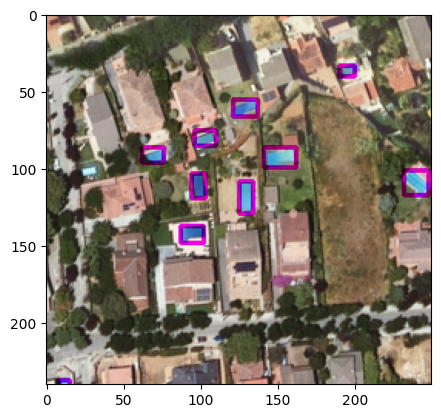

In [7]:
# Lee el archivo shapefile
regions = gpd.read_file('..\\data\\Zona\\clean\\bt5mv20sh0f286122hp1r060.shp')

xmin_window, ymin_window, xmax_window, ymax_window = 420660, 4590892, 420785, 4591012

# Recorta el GeoTIFF según las coordenadas de la window
window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
clipped_data = dataset.read(window=window)
clipped_data = np.moveaxis(clipped_data, 0, -1)

# Muestra todas las regiones de interés en la window
for region in regions.geometry:
    xmin, ymin, xmax, ymax = region.bounds

    xmin, ymin, xmax, ymax = image_to_window((xmin, ymin, xmax, ymax), (xmin_window, ymin_window), dataset.transform, clipped_data.shape)

    # Dibuja los rectángulos
    cv2.rectangle(clipped_data[:, :, 1], (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

# Visualiza la ventana con los rectángulos
plt.imshow(clipped_data)
plt.show()

In [110]:
Ninf = 50
Nsup = 100
n_image = 1
n_total = 1

list_regions = []
for file in os.listdir("..\data\Zona\clean"):
    if file.endswith(".shp"):
        regions = gpd.read_file(f'..\\data\\Zona\\clean\\{file}')
        list_regions.append(regions)

annotations = []
for regions in list_regions:
    for region in regions.geometry:
        n_id = 1
        xmin, ymin, xmax, ymax = region.bounds

        xmin_window = xmin - random.randint(Ninf, Nsup)
        ymin_window = ymin - random.randint(Ninf, Nsup)
        xmax_window = xmax + random.randint(Ninf, Nsup)
        ymax_window = ymax + random.randint(Ninf, Nsup)

        # Recorta el GeoTIFF según las coordenadas de la window
        window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
        clipped_data = dataset.read(window=window)
        clipped_data = np.moveaxis(clipped_data, 0, -1)

        # Muestra todas las regiones de interés en la window
        for regions2 in list_regions:
            for region2 in regions2.geometry:
                xmin, ymin, xmax, ymax = region2.bounds
                # if region in window
                if xmin > xmin_window and ymin > ymin_window and xmax < xmax_window and ymax < ymax_window:
                    annotation = dict()
                    annotation['category_id'] = 1
                    annotation['id_of_image'] = n_image
                    annotation['id_in_image'] = n_id
                    annotation['id_total'] = n_total
                    annotation['bbox'] = xyxy_to_cxcywh(region2.bounds)
                    annotation['segmentation'] = [(x, y) for x, y in zip(region2.exterior.coords.xy[0], region2.exterior.coords.xy[1])]
                    n_id += 1
                    n_total += 1
                    annotations.append(annotation)
        n_image += 1

In [111]:
import json
with open('..\\data\\Zona\\Dataset\\annotations\\annotations.json', 'w') as f:
    json.dump(annotations, f)

In [30]:
import torch

In [33]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)

Using cache found in C:\Users\rober/.cache\torch\hub\facebookresearch_detr_main
d:\Clase\TFG\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Clase\TFG\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\rober/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to C:\Users\rober/.cache\torch\hub\checkpoints\detr-r50-e632da11.pth
100.0%


In [34]:
model.eval()

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou